In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, RocCurveDisplay)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# Load dataset
df = pd.read_csv("Heart-Disease-Dataset.csv")
df = df.dropna()

X = df.drop(columns=["target"]).values.astype(np.float32)
y = df["target"].values.astype(np.float32)

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [6]:
# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [8]:
# ANN model
class ANN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.fc(x)


In [9]:
# LSTM model
class LSTMNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size=64, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        if x.ndim == 2:
            x = x.unsqueeze(1)  # shape: (B, 1, features)
        x, _ = self.lstm(x)
        return self.fc(x[:, -1, :])

In [14]:
# CNN model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 64, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear((13 - 2)*64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

In [15]:
# CNN-LSTM model
class CNNLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(1, 64, 3)
        self.lstm = nn.LSTM(64, 64, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.conv(x)              # (B, 64, seq_len-2)
        x = x.permute(0, 2, 1)        # (B, seq_len-2, 64)
        x, _ = self.lstm(x)
        return self.fc(x[:, -1, :])

In [16]:
# Helper function to train and get predictions
def train_model(model, train_loader, X_test_tensor, y_test_tensor, reshape_input_fn=None):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(10):
        for xb, yb in train_loader:
            if reshape_input_fn:
                xb = reshape_input_fn(xb)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.no_grad():
        X_test_input = reshape_input_fn(X_test_tensor) if reshape_input_fn else X_test_tensor
        y_score = model(X_test_input).numpy()
    return y_score

In [17]:
# Train and evaluate each model
input_size = X_train.shape[1]

ann_model = ANN(input_size)
ann_score = train_model(ann_model, train_loader, X_test_tensor, y_test_tensor)

lstm_model = LSTMNet(input_size)
lstm_score = train_model(lstm_model, train_loader, X_test_tensor, y_test_tensor, lambda x: x.unsqueeze(1))

cnn_model = CNN()
cnn_score = train_model(cnn_model, train_loader, X_test_tensor, y_test_tensor, lambda x: x.unsqueeze(1))

cnn_lstm_model = CNNLSTM()
cnn_lstm_score = train_model(cnn_lstm_model, train_loader, X_test_tensor, y_test_tensor, lambda x: x.unsqueeze(1))

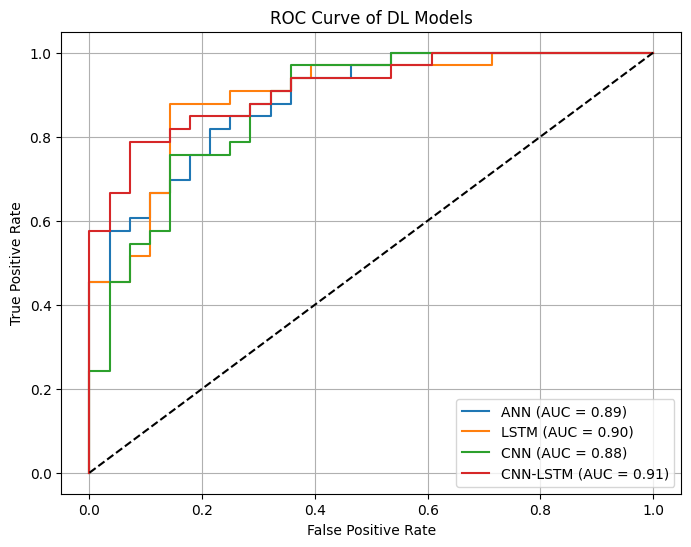

In [18]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
for name, score in zip([
    "ANN", "LSTM", "CNN", "CNN-LSTM"],
    [ann_score, lstm_score, cnn_score, cnn_lstm_score]):
    fpr, tpr, _ = roc_curve(y_test, score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of DL Models")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# Metrics for each model
def print_metrics(name, y_score):
    y_pred_class = (y_score >= 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_class)
    precision = precision_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class)
    auc_val = roc_auc_score(y_test, y_score)
    print(f"{name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc_val:.4f}\n")

print_metrics("ANN", ann_score)
print_metrics("LSTM", lstm_score)
print_metrics("CNN", cnn_score)
print_metrics("CNN-LSTM", cnn_lstm_score)

ANN Metrics:
Accuracy: 0.7705, Precision: 0.7436, Recall: 0.8788, F1: 0.8056, AUC: 0.8896

LSTM Metrics:
Accuracy: 0.8033, Precision: 0.7692, Recall: 0.9091, F1: 0.8333, AUC: 0.8972

CNN Metrics:
Accuracy: 0.7869, Precision: 0.7632, Recall: 0.8788, F1: 0.8169, AUC: 0.8755

CNN-LSTM Metrics:
Accuracy: 0.7705, Precision: 0.7209, Recall: 0.9394, F1: 0.8158, AUC: 0.9145



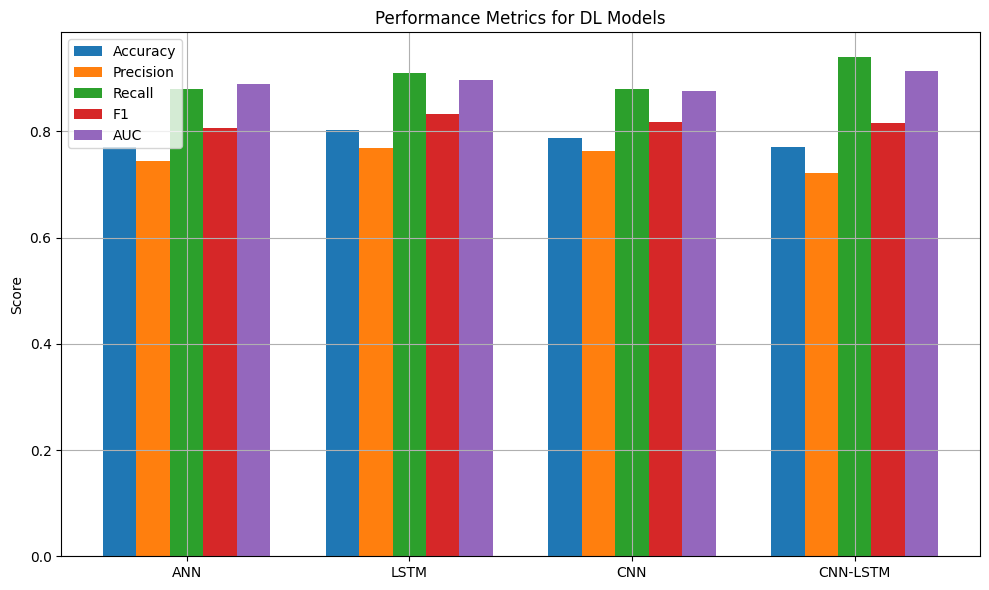

In [21]:
# Bar chart of metrics
def plot_metrics_chart():
    models = ["ANN", "LSTM", "CNN", "CNN-LSTM"]
    scores = [ann_score, lstm_score, cnn_score, cnn_lstm_score]
    metrics = {"Accuracy": [], "Precision": [], "Recall": [], "F1": [], "AUC": []}

    for score in scores:
        pred_class = (score >= 0.5).astype(int)
        metrics["Accuracy"].append(accuracy_score(y_test, pred_class))
        metrics["Precision"].append(precision_score(y_test, pred_class))
        metrics["Recall"].append(recall_score(y_test, pred_class))
        metrics["F1"].append(f1_score(y_test, pred_class))
        metrics["AUC"].append(roc_auc_score(y_test, score))

    x = np.arange(len(models))
    width = 0.15

    plt.figure(figsize=(10, 6))
    for idx, (metric, values) in enumerate(metrics.items()):
        plt.bar(x + idx*width, values, width, label=metric)

    plt.xticks(x + width*2, models)
    plt.ylabel("Score")
    plt.title("Performance Metrics for DL Models")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metrics_chart()
